# Thermally tuned waveguide

In this example we use Tidy3D's heat solver to investigate tuning of a straight rectangular waveguide using a heating strip.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import tidy3d as td
import tidy3d.web as web


## Setup Simulation Scene

The simulation setup consists of a silicon waveguide in a silicon dioxide cladding on top of a silicon wafer. The heating strip is placed in the cladding above the waveguide. Let us define basic geometric parameters of simulated structures.

In [2]:
# in um

w_sim = 16  # simulation width
h_buffer = 1  # vertical simulation buffer

h_clad = 2.8  # thickness of cladding
h_box = 2  # thickness of buried oxide
h_wafer = 0.5  # wafer thickness

# waveguide parameters
w_core = 0.5
h_core = 0.22

# heater parameters
h_heater = 0.14
w_heater = 2
d_heater = 2  # distance between heater and waveguide


We will place the wafer's top surface at location $z=0$. Let us define vertical locations of each structure. Note that we will model buried oxide and cladding as a single structure since they are made of the same material.

In [3]:
z_wafer = -h_wafer / 2
z_core = h_box + h_core / 2
z_heater = h_box + h_core + d_heater + h_heater / 2

box_clad_max = h_box + h_clad
box_clad_min = (
    -h_wafer / 2
)  # make structures overlap to ensure no gaps due to numerical roundoff errors
h_box_clad = box_clad_max - box_clad_min
z_box_clad = (box_clad_max + box_clad_min) / 2

z_sim = (h_box + h_clad - h_wafer) / 2
h_sim = h_box + h_clad + h_wafer + 2 * h_buffer


Define optic and thermal properties of materials.

In [4]:
Si_n = 3.4777  # Si refraction index
Si_n_slope = 1.86e-4  # Si thermo-optic coefficient dn/dT, 1/K
Si_k = 148e-12  # Si thermal conductivity, W / (um * K)
Si_s = 0.71 * 2.33e-12  # Si volumetric heat capacity, J / (um^3 * K)

SiO2_n = 1.444  # SiO2 refraction index
SiO2_n_slope = 1e-5  # SiO2 thermo-optic coefficient dn/dT, 1/K
SiO2_k = 1.38e-12  # SiO2 thermal conductivity, W/(um*K)
SiO2_s = 0.709 * 2.203e-12  # SiO2 volumetric heat capacity, J / (um^3 * K)

TiN_k = 28e-12  # TiN thermal conductivity W/(um*K)
TiN_s = 0.598 * 5240e-12  # TiN volumetric heat capacityJ / (um^3 * K)
TiN_sigma = 2.3e6  # Electric conductivity of TiN, S/m


Convert refraction indices into permittivity values.

In [5]:
Si_eps = Si_n**2
Si_eps_slope = 2 * Si_n * Si_n_slope

SiO2_eps = SiO2_n**2
SiO2_eps_slope = 2 * SiO2_n * SiO2_n_slope


Create material classes containing relevant information for each medium. Note that we use class [PerturbationMedium](../_autosummary/tidy3d.PerturbationMedium.html) to specify sensitivity of optic properties to temperature and field `heat_spec` to specify thermal properties. Optic characteristics of the heating strip material is modeled as a perfect electric conductor.

In [6]:
Si = td.PerturbationMedium(
    permittivity=Si_eps,
    permittivity_perturbation=td.ParameterPerturbation(
        heat=td.LinearHeatPerturbation(coeff=Si_eps_slope, temperature_ref=300)
    ),
    heat_spec=td.SolidSpec(
        conductivity=Si_k,
        capacity=Si_s,
    ),
    name="Si",
)

SiO2 = td.PerturbationMedium(
    permittivity=SiO2_eps,
    permittivity_perturbation=td.ParameterPerturbation(
        heat=td.LinearHeatPerturbation(coeff=SiO2_eps_slope, temperature_ref=300)
    ),
    heat_spec=td.SolidSpec(
        conductivity=SiO2_k,
        capacity=SiO2_s,
    ),
    name="SiO2",
)

TiN = td.PECMedium(
    heat_spec=td.SolidSpec(
        conductivity=TiN_k,
        capacity=TiN_s,
    ),
    name="TiN",
)

air = td.Medium(heat_spec=td.FluidSpec(), name="air")


Create structures representing waveguide, heater, cladding, and wafer.

In [7]:
core = td.Structure(
    geometry=td.Box(center=(0, 0, z_core), size=(w_core, td.inf, h_core)),
    medium=Si,
)

heater = td.Structure(
    geometry=td.Box(center=(0, 0, z_heater), size=(w_heater, td.inf, h_heater)),
    medium=TiN,
    name="heater",
)

box_clad = td.Structure(
    geometry=td.Box(center=(0, 0, z_box_clad), size=(td.inf, td.inf, h_box_clad)),
    medium=SiO2,
)

wafer = td.Structure(
    geometry=td.Box(center=(0, 0, z_wafer), size=(td.inf, td.inf, h_wafer)),
    medium=Si,
    name="wafer",
)


Pack structures into a simulation scene.

In [8]:
scene = td.Scene(
    medium=air,
    structures=[box_clad, core, heater, wafer],
)


Visual validation of the setup.

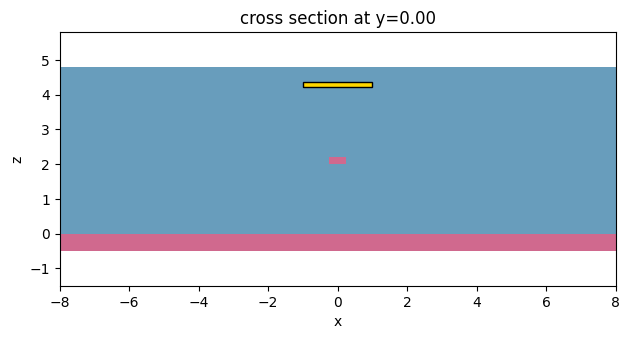

In [9]:
scene.plot(
    y=0, hlim=[-w_sim / 2, w_sim / 2], vlim=[z_sim - h_sim / 2, z_sim + h_sim / 2]
)
plt.show()


## Setup Heat Simulation

We assume that the bottom of the wafer is maintained at temperature $T=300$ K and ignore heat transfer at the cladding/air boundary. In this simulation setup these boundary conditions can be set using [MediumMediumInterface](../_autosummary/tidy3d.MediumMediumInterface.html) placement. Note since no other boundary conditions are specified, the other sides of the simulation box will be treated as insulating boundary conditions.

Convective cooling/heating at the cladding/air boundary can be easily taken into account using [ConvectionBC](../_autosummary/tidy3d.ConvectionBC.html) boundary conditions.

In [10]:
bc_bottom = td.HeatBoundarySpec(
    placement=td.MediumMediumInterface(mediums=["Si", "air"]),
    condition=td.TemperatureBC(temperature=300),
)

bc_top = td.HeatBoundarySpec(
    placement=td.MediumMediumInterface(mediums=["SiO2", "air"]),
    condition=td.HeatFluxBC(flux=0),
)


Create a uniform heat source inside the heater structure equivalent to electrical current of $7.3 \times 10^{-3}$ A.

In [11]:
current = 7.4e-3  # A
heat_rate = (current / h_heater / w_heater) ** 2 / TiN_sigma  # convert into power
heater_source = td.UniformHeatSource(rate=heat_rate, structures=[heater.name])


We will measure temperature distribution in the entire cross section of the simulation setup. Note that in this example we request to return heat solver results on the original unstructured grid. Moreover, we request the monitor plane to be meshed conformally.

In [12]:
temp_mnt = td.TemperatureMonitor(size=(td.inf, 0, td.inf), name="temperature", unstructured=True, conformal=True)


For spatial discretization we will use a distance-based meshing specifying that solid-solid material interfaces should be discretized with mesh size equal to the heater height `h_heater` divided by 3 and away from interfaces the grid should coarsen to four times of that size. Setting `distance_interface` to three of minimal mesh size will create approximately three layers of cells with the minimal size around interfaces. Cells outside of this region will have sizes according to linear relation `dl_interface * (1 - ratio(d)) + dl_interface * ratio(d)`, where `ratio(d) = (d - distance_interface) / (distance_bulk - distance_interface)` and `d` is the distance to the closest material interface. We choose this transition to happen on the order of `2 * d_heater`. We will also exclude using the higher mesh resolution around the wafer since that region is of less interest.

In [13]:
# parameters for meshing
dl_min = h_heater / 3
dl_max = 4 * dl_min

grid_spec = td.DistanceUnstructuredGrid(
    dl_interface=dl_min,
    dl_bulk=dl_max,
    distance_interface=3 * dl_min,
    distance_bulk=2 * d_heater,
    non_refined_structures=["wafer"],  # do not refine near wafer
)


Pack components into a heat simulation specification. Note that from the heat transfer perspective the problem is symmetric around $x=0$. Thus, we can set symmetry specification to `(1, 0, 0)` to reduce simulation size and cost. 

Given that the problem is two-dimensional we will use a small simulation size along the invariant $y$-direction.

In [14]:
heat_sim = td.HeatSimulation.from_scene(
    scene=scene,
    center=(0, 0, z_sim),
    size=(w_sim, dl_min, h_sim),
    boundary_spec=[bc_bottom, bc_top],
    sources=[heater_source],
    monitors=[temp_mnt],
    symmetry=(1, 0, 0),
    grid_spec=grid_spec,
)


09:47:45 CST WARNING: More than 2 different solid zones (zone = medium + source)
             are detected in the heat simulation. Make sure no more than 2 solid
             zones are adjacent to each other anywhere in the simulation domain.
             The simulation results may be inaccurate otherwise. This           
             restriction will be removed in the upcoming Tidy3D versions.       

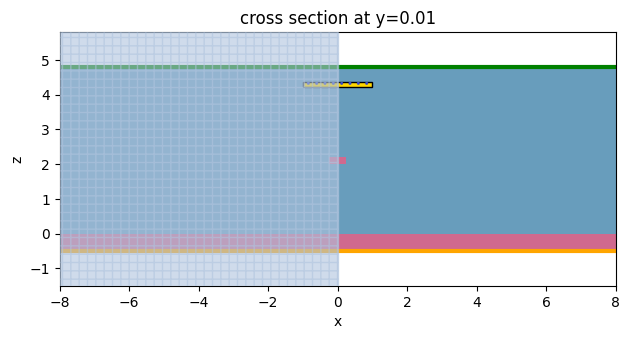

In [15]:
heat_sim.plot(y=0.01)
plt.show()


## Mesh Inspection

Before proceeding to submitting a parameter sweep batch we run one simulation and inspect its mesh and solution.

In [16]:
job = web.Job(simulation=heat_sim, task_name="heat_sim_check_mesh", solver_version="unstructured-mnt-0.0.0")
heat_sim_data = job.run()


             Created task 'heat_sim_check_mesh' with task_id                    
             'he-6ca3d7e2-6043-4238-8be6-2075b2fb2fae' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. All heat      
             simulations are charged a flat fee of 0.025 FlexCredit.

Output()

09:47:47 CST Heat solver status: queued

09:47:51 CST Heat solver status: preprocess

09:48:30 CST Heat solver status: running

09:48:32 CST Heat solver status: postprocess

09:48:39 CST Heat solver status: success

Output()

09:48:40 CST loading simulation from simulation_data.hdf5

09:48:41 CST WARNING: More than 2 different solid zones (zone = medium + source)
             are detected in the heat simulation. Make sure no more than 2 solid
             zones are adjacent to each other anywhere in the simulation domain.
             The simulation results may be inaccurate otherwise. This           
             restriction will be removed in the upcoming Tidy3D versions.       

Since while setting up the temperature monitor we requested to return data on unstructured grid, we can plot the associated monitor data to visualize both the solver mesh and the solution.

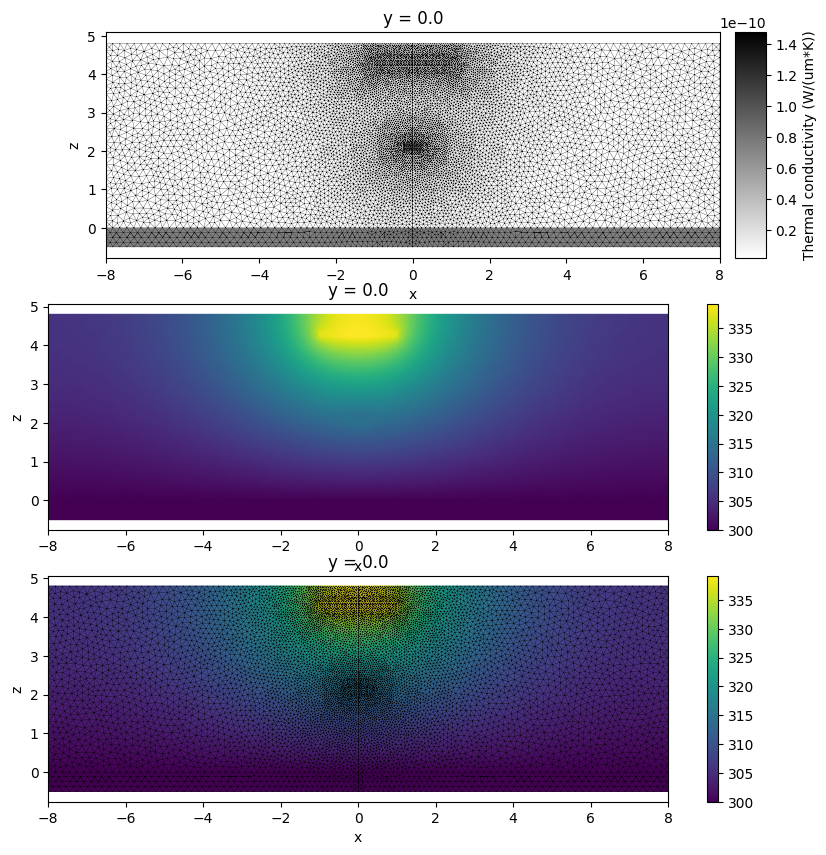

In [17]:
_, ax = plt.subplots(3, 1, figsize=(10, 10))

heat_sim.plot_structures_heat_conductivity(y=0, alpha=0.5, ax=ax[0])
heat_sim_data["temperature"].temperature.plot(ax=ax[0], field=False)
ax[0].set_xlim([-8, 8])

heat_sim_data["temperature"].temperature.plot(ax=ax[1], grid=False)
ax[1].set_xlim([-8, 8])

heat_sim_data["temperature"].temperature.plot(ax=ax[2])
ax[2].set_xlim([-8, 8])

plt.show()

## Batch Processing of Heat Simulations

Having ensured that the simulation mesh is suitable for this simulation setup, let us perform a sweep through several values of electric current in the heating strip. To do this we create a dictionary of simulations with different source definitions.

In [18]:
currents = np.linspace(1e-10, 7.4e-3, 10)
heat_sims = {}

for ind, current in enumerate(currents):
    heat_rate = (current / h_heater / w_heater) ** 2 / TiN_sigma
    heater_source = td.UniformHeatSource(rate=heat_rate, structures=[heater.name])

    heat_sim_new = heat_sim.updated_copy(sources=[heater_source])
    heat_sims[f"heat_wg_current_{ind}"] = heat_sim_new


             WARNING: More than 2 different solid zones (zone = medium + source)
             are detected in the heat simulation. Make sure no more than 2 solid
             zones are adjacent to each other anywhere in the simulation domain.
             The simulation results may be inaccurate otherwise. This           
             restriction will be removed in the upcoming Tidy3D versions.       

             WARNING: More than 2 different solid zones (zone = medium + source)
             are detected in the heat simulation. Make sure no more than 2 solid
             zones are adjacent to each other anywhere in the simulation domain.
             The simulation results may be inaccurate otherwise. This           
             restriction will be removed in the upcoming Tidy3D versions.       

             WARNING: More than 2 different solid zones (zone = medium + source)
             are detected in the heat simulation. Make sure no more than 2 solid
             zones are adjacent to each other anywhere in the simulation domain.
             The simulation results may be inaccurate otherwise. This           
             restriction will be removed in the upcoming Tidy3D versions.       

             WARNING: More than 2 different solid zones (zone = medium + source)
             are detected in the heat simulation. Make sure no more than 2 solid
             zones are adjacent to each other anywhere in the simulation domain.
             The simulation results may be inaccurate otherwise. This           
             restriction will be removed in the upcoming Tidy3D versions.       

             WARNING: More than 2 different solid zones (zone = medium + source)
             are detected in the heat simulation. Make sure no more than 2 solid
             zones are adjacent to each other anywhere in the simulation domain.
             The simulation results may be inaccurate otherwise. This           
             restriction will be removed in the upcoming Tidy3D versions.       

             WARNING: More than 2 different solid zones (zone = medium + source)
             are detected in the heat simulation. Make sure no more than 2 solid
             zones are adjacent to each other anywhere in the simulation domain.
             The simulation results may be inaccurate otherwise. This           
             restriction will be removed in the upcoming Tidy3D versions.       

             WARNING: More than 2 different solid zones (zone = medium + source)
             are detected in the heat simulation. Make sure no more than 2 solid
             zones are adjacent to each other anywhere in the simulation domain.
             The simulation results may be inaccurate otherwise. This           
             restriction will be removed in the upcoming Tidy3D versions.       

             WARNING: More than 2 different solid zones (zone = medium + source)
             are detected in the heat simulation. Make sure no more than 2 solid
             zones are adjacent to each other anywhere in the simulation domain.
             The simulation results may be inaccurate otherwise. This           
             restriction will be removed in the upcoming Tidy3D versions.       

             WARNING: More than 2 different solid zones (zone = medium + source)
             are detected in the heat simulation. Make sure no more than 2 solid
             zones are adjacent to each other anywhere in the simulation domain.
             The simulation results may be inaccurate otherwise. This           
             restriction will be removed in the upcoming Tidy3D versions.       

             WARNING: More than 2 different solid zones (zone = medium + source)
             are detected in the heat simulation. Make sure no more than 2 solid
             zones are adjacent to each other anywhere in the simulation domain.
             The simulation results may be inaccurate otherwise. This           
             restriction will be removed in the upcoming Tidy3D versions.       

And submit this dictionary using [Batch](../_autosummary/tidy3d.web.Batch.html) functionality.

In [19]:
batch = web.Batch(simulations=heat_sims, solver_version="unstructured-mnt-0.0.0")


             Created task 'heat_wg_current_0' with task_id                      
             'he-f74f5188-87fa-4677-bbfe-85a8d1146703' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. All heat      
             simulations are charged a flat fee of 0.025 FlexCredit.

Output()

09:48:42 CST Created task 'heat_wg_current_1' with task_id                      
             'he-0b42be14-e2c0-4724-8b9f-45befa385d40' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. All heat      
             simulations are charged a flat fee of 0.025 FlexCredit.

Output()

09:48:43 CST Created task 'heat_wg_current_2' with task_id                      
             'he-09c50abd-a94f-4426-aefd-acf392dd7a51' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. All heat      
             simulations are charged a flat fee of 0.025 FlexCredit.

Output()

09:48:44 CST Created task 'heat_wg_current_3' with task_id                      
             'he-31c30f87-c921-40ad-b72c-e371231c2f85' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. All heat      
             simulations are charged a flat fee of 0.025 FlexCredit.

Output()

09:48:45 CST Created task 'heat_wg_current_4' with task_id                      
             'he-3c3388ef-b165-4325-a08a-0072e0a7c04d' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. All heat      
             simulations are charged a flat fee of 0.025 FlexCredit.

Output()

             Created task 'heat_wg_current_5' with task_id                      
             'he-fa208e78-3cbc-45a3-a925-459ddeed6d3e' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. All heat      
             simulations are charged a flat fee of 0.025 FlexCredit.

Output()

09:48:46 CST Created task 'heat_wg_current_6' with task_id                      
             'he-74c8fc25-fde6-4de2-87ac-3c862d78342d' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. All heat      
             simulations are charged a flat fee of 0.025 FlexCredit.

Output()

09:48:47 CST Created task 'heat_wg_current_7' with task_id                      
             'he-fe067b20-26d9-47fe-973a-72fd55d3087c' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. All heat      
             simulations are charged a flat fee of 0.025 FlexCredit.

Output()

09:48:48 CST Created task 'heat_wg_current_8' with task_id                      
             'he-4635a7b6-b080-4180-b201-f71f0e7c0039' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. All heat      
             simulations are charged a flat fee of 0.025 FlexCredit.

Output()

             Created task 'heat_wg_current_9' with task_id                      
             'he-5fa0165b-593d-4878-b434-ec99739722fe' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. All heat      
             simulations are charged a flat fee of 0.025 FlexCredit.

Output()

In [20]:
batch_data = batch.run()


09:48:53 CST Started working on Batch.

09:48:57 CST Maximum FlexCredit cost: 0.250 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

09:53:17 CST Batch complete.

Visualize some of the simulation results.

Output()

09:53:20 CST loading simulation from                                            
             ./he-0b42be14-e2c0-4724-8b9f-45befa385d40.hdf5

             WARNING: More than 2 different solid zones (zone = medium + source)
             are detected in the heat simulation. Make sure no more than 2 solid
             zones are adjacent to each other anywhere in the simulation domain.
             The simulation results may be inaccurate otherwise. This           
             restriction will be removed in the upcoming Tidy3D versions.       

Output()

09:53:21 CST loading simulation from                                            
             ./he-fa208e78-3cbc-45a3-a925-459ddeed6d3e.hdf5

             WARNING: More than 2 different solid zones (zone = medium + source)
             are detected in the heat simulation. Make sure no more than 2 solid
             zones are adjacent to each other anywhere in the simulation domain.
             The simulation results may be inaccurate otherwise. This           
             restriction will be removed in the upcoming Tidy3D versions.       

Output()

09:53:23 CST loading simulation from                                            
             ./he-5fa0165b-593d-4878-b434-ec99739722fe.hdf5

             WARNING: More than 2 different solid zones (zone = medium + source)
             are detected in the heat simulation. Make sure no more than 2 solid
             zones are adjacent to each other anywhere in the simulation domain.
             The simulation results may be inaccurate otherwise. This           
             restriction will be removed in the upcoming Tidy3D versions.       

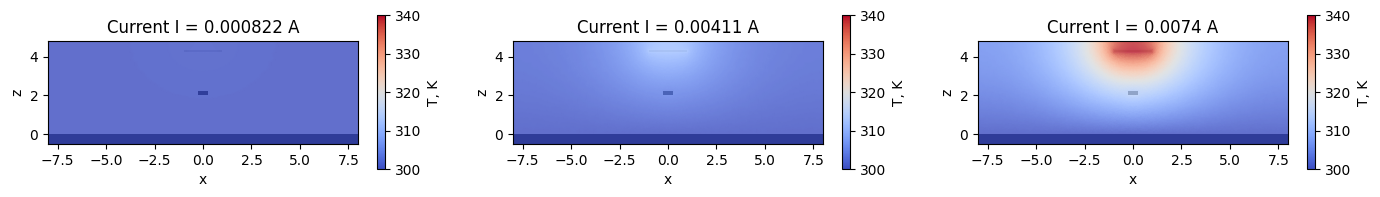

In [21]:
# max temperature value when plotting to enforce the same coloring
temp_max_plot = 340

fig, ax = plt.subplots(1, 3, figsize=(17, 2))

batch_data["heat_wg_current_1"].plot_field("temperature", ax=ax[0], vmax=temp_max_plot)
ax[0].set_title(f"Current I = {currents[1]:1.3} A")

batch_data["heat_wg_current_5"].plot_field("temperature", ax=ax[1], vmax=temp_max_plot)
ax[1].set_title(f"Current I = {currents[5]:1.3} A")

batch_data["heat_wg_current_9"].plot_field("temperature", ax=ax[2], vmax=temp_max_plot)
ax[2].set_title(f"Current I = {currents[9]:1.3} A")

plt.show()


## Coupling to Optic Simulations

Now let us create optic simulations where material properties are modified according to obtained temperature distributions. One can conveniently do that using method `.perturbed_mediums_copy()` of classes [Scene](../_autosummary/tidy3d.Scene.html) and [Simulation](../_autosummary/tidy3d.Simulation.html). We will use obtained optic simulations only to investigate waveguide modes, thus we are defining neither sources nor monitors, and only provide grid specification.

Recall that in this tutorial we chose to retrieve heat solver results on an unstructured grid. However, currently method `.perturbed_mediums_copy()` supports only Cartesian arrays `SpatialDataArray`. Thus, we need to interpolate the unstructured data array onto a suitable Cartesian grid. To this end, we first create an unperturbed optic simulation.

In [22]:
wvl_um = 1.55
freq0 = td.C_0 / wvl_um

grid_spec = td.GridSpec.auto(min_steps_per_wvl=50, wavelength=wvl_um)

optic_sim = td.Simulation.from_scene(
    scene=scene,
    center=(0, 0, z_sim),
    size=(w_sim, dl_min, h_sim),
    run_time=1e-15,
    grid_spec=grid_spec,
)

Now we can use its grid as the target grid to interpolate the temperature fields to.

In [23]:
target_grid = optic_sim.grid.boundaries
perturb_sims = []

for _, hs_data in batch_data.items():
    temp_interpolated = hs_data["temperature"].temperature.interp(x=target_grid.x, y=0, z=target_grid.z, fill_value=300)
    psim = optic_sim.perturbed_mediums_copy(temperature=temp_interpolated)
    perturb_sims.append(psim)


Output()

09:53:24 CST loading simulation from                                            
             ./he-f74f5188-87fa-4677-bbfe-85a8d1146703.hdf5

             WARNING: More than 2 different solid zones (zone = medium + source)
             are detected in the heat simulation. Make sure no more than 2 solid
             zones are adjacent to each other anywhere in the simulation domain.
             The simulation results may be inaccurate otherwise. This           
             restriction will be removed in the upcoming Tidy3D versions.       

09:53:25 CST loading simulation from                                            
             ./he-0b42be14-e2c0-4724-8b9f-45befa385d40.hdf5

             WARNING: More than 2 different solid zones (zone = medium + source)
             are detected in the heat simulation. Make sure no more than 2 solid
             zones are adjacent to each other anywhere in the simulation domain.
             The simulation results may be inaccurate otherwise. This           
             restriction will be removed in the upcoming Tidy3D versions.       

Output()

09:53:27 CST loading simulation from                                            
             ./he-09c50abd-a94f-4426-aefd-acf392dd7a51.hdf5

             WARNING: More than 2 different solid zones (zone = medium + source)
             are detected in the heat simulation. Make sure no more than 2 solid
             zones are adjacent to each other anywhere in the simulation domain.
             The simulation results may be inaccurate otherwise. This           
             restriction will be removed in the upcoming Tidy3D versions.       

Output()

09:53:29 CST loading simulation from                                            
             ./he-31c30f87-c921-40ad-b72c-e371231c2f85.hdf5

             WARNING: More than 2 different solid zones (zone = medium + source)
             are detected in the heat simulation. Make sure no more than 2 solid
             zones are adjacent to each other anywhere in the simulation domain.
             The simulation results may be inaccurate otherwise. This           
             restriction will be removed in the upcoming Tidy3D versions.       

Output()

09:53:32 CST loading simulation from                                            
             ./he-3c3388ef-b165-4325-a08a-0072e0a7c04d.hdf5

             WARNING: More than 2 different solid zones (zone = medium + source)
             are detected in the heat simulation. Make sure no more than 2 solid
             zones are adjacent to each other anywhere in the simulation domain.
             The simulation results may be inaccurate otherwise. This           
             restriction will be removed in the upcoming Tidy3D versions.       

09:53:33 CST loading simulation from                                            
             ./he-fa208e78-3cbc-45a3-a925-459ddeed6d3e.hdf5

             WARNING: More than 2 different solid zones (zone = medium + source)
             are detected in the heat simulation. Make sure no more than 2 solid
             zones are adjacent to each other anywhere in the simulation domain.
             The simulation results may be inaccurate otherwise. This           
             restriction will be removed in the upcoming Tidy3D versions.       

Output()

09:53:35 CST loading simulation from                                            
             ./he-74c8fc25-fde6-4de2-87ac-3c862d78342d.hdf5

             WARNING: More than 2 different solid zones (zone = medium + source)
             are detected in the heat simulation. Make sure no more than 2 solid
             zones are adjacent to each other anywhere in the simulation domain.
             The simulation results may be inaccurate otherwise. This           
             restriction will be removed in the upcoming Tidy3D versions.       

Output()

09:53:37 CST loading simulation from                                            
             ./he-fe067b20-26d9-47fe-973a-72fd55d3087c.hdf5

             WARNING: More than 2 different solid zones (zone = medium + source)
             are detected in the heat simulation. Make sure no more than 2 solid
             zones are adjacent to each other anywhere in the simulation domain.
             The simulation results may be inaccurate otherwise. This           
             restriction will be removed in the upcoming Tidy3D versions.       

Output()

09:53:39 CST loading simulation from                                            
             ./he-4635a7b6-b080-4180-b201-f71f0e7c0039.hdf5

             WARNING: More than 2 different solid zones (zone = medium + source)
             are detected in the heat simulation. Make sure no more than 2 solid
             zones are adjacent to each other anywhere in the simulation domain.
             The simulation results may be inaccurate otherwise. This           
             restriction will be removed in the upcoming Tidy3D versions.       

09:53:40 CST loading simulation from                                            
             ./he-5fa0165b-593d-4878-b434-ec99739722fe.hdf5

             WARNING: More than 2 different solid zones (zone = medium + source)
             are detected in the heat simulation. Make sure no more than 2 solid
             zones are adjacent to each other anywhere in the simulation domain.
             The simulation results may be inaccurate otherwise. This           
             restriction will be removed in the upcoming Tidy3D versions.       

Define plane where waveguide modes will be calculated.

In [24]:
mode_plane = td.Box(center=(0, 0, z_core), size=(4, 0, 3))


Visual inspection.

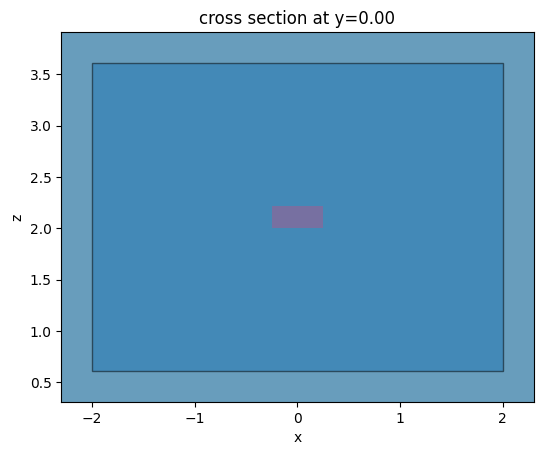

In [25]:
fig, ax = plt.subplots(1, 1)
perturb_sims[0].plot(y=0, ax=ax)
mode_plane.plot(y=0, ax=ax, alpha=0.5)
plt.show()


We will use Tidy3D's mode solver plugin.

In [26]:
from tidy3d.plugins.mode.web import run as run_mode
from tidy3d.plugins.mode import ModeSolver


Find only the first mode at the frequency corresponding to 1.55 um wavelength.

In [27]:
mode_datas = []

for psim in perturb_sims:
    ms = ModeSolver(
        simulation=psim,
        plane=mode_plane,
        mode_spec=td.ModeSpec(num_modes=1, precision="double"),
        freqs=[freq0],
    )

    md = run_mode(ms)

    mode_datas.append(md)


09:53:41 CST Mode solver created with                                           
             task_id='fdve-e2c9a3aa-29c9-4543-9a31-4f902cbb13bf',               
             solver_id='mo-e76fa5f3-ce8b-423b-b2a8-53b346a42ef1'.

Output()

Output()

09:53:44 CST Mode solver status: queued

09:53:57 CST Mode solver status: running

09:54:13 CST Mode solver status: success

Output()

09:54:15 CST Mode solver created with                                           
             task_id='fdve-8dee916a-b4f6-43de-b590-cc8a8eaa1d8c',               
             solver_id='mo-cfa38f73-66fe-4fdd-851e-9ae97cdae8fc'.

Output()

Output()

09:54:18 CST Mode solver status: queued

09:54:34 CST Mode solver status: running

09:54:49 CST Mode solver status: success

Output()

09:54:53 CST Mode solver created with                                           
             task_id='fdve-36b3e8e1-dfd1-441f-97df-d20e30a389d6',               
             solver_id='mo-a7d87586-7416-4172-a514-13705451cbb2'.

Output()

Output()

09:54:57 CST Mode solver status: queued

09:55:09 CST Mode solver status: running

09:55:26 CST Mode solver status: success

Output()

09:55:30 CST Mode solver created with                                           
             task_id='fdve-d7bde6cd-9b84-4028-b8e1-43099530ae6c',               
             solver_id='mo-b705e091-73f2-4ab8-b5ca-043d6477ebac'.

Output()

Output()

09:55:34 CST Mode solver status: queued

09:55:46 CST Mode solver status: running

09:56:16 CST Mode solver status: success

Output()

09:56:21 CST Mode solver created with                                           
             task_id='fdve-2bbd36dd-6238-4d36-a72e-e5231a1d31d6',               
             solver_id='mo-f4e23c73-db8c-4fe1-a93e-4beb03db1561'.

Output()

Output()

09:56:24 CST Mode solver status: queued

09:56:36 CST Mode solver status: running

09:56:51 CST Mode solver status: success

Output()

09:56:55 CST Mode solver created with                                           
             task_id='fdve-51589d2f-f054-4815-93de-37780d5e908d',               
             solver_id='mo-5237865b-b309-4e0f-acc9-03076fd2dd00'.

Output()

Output()

09:56:58 CST Mode solver status: queued

09:57:10 CST Mode solver status: running

09:57:36 CST Mode solver status: success

Output()

09:57:39 CST Mode solver created with                                           
             task_id='fdve-26c119ce-9891-4e6c-9d08-321533634e9b',               
             solver_id='mo-26384ce5-18b1-43f2-85b7-2011ef421219'.

Output()

Output()

09:57:43 CST Mode solver status: queued

09:57:55 CST Mode solver status: running

09:58:23 CST Mode solver status: success

Output()

09:58:26 CST Mode solver created with                                           
             task_id='fdve-e898967f-c9c2-4251-885e-4e603ce4fff4',               
             solver_id='mo-71bd6f9b-05cf-44c2-95e8-3aa03310d5c9'.

Output()

Output()

09:58:30 CST Mode solver status: queued

09:58:41 CST Mode solver status: running

09:59:47 CST Mode solver status: success

Output()

09:59:49 CST Mode solver created with                                           
             task_id='fdve-ebd42c40-4ded-4ccb-8418-a4b9fdf62687',               
             solver_id='mo-029563a4-ecfa-4f8d-b495-5a495bcf1da7'.

Output()

Output()

09:59:54 CST Mode solver status: queued

10:00:05 CST Mode solver status: running

10:00:33 CST Mode solver status: success

Output()

10:00:37 CST Mode solver created with                                           
             task_id='fdve-7c8265ba-e285-4282-b90d-e4ed22f799b5',               
             solver_id='mo-7fc0674d-48f9-4b18-ae74-aaf0d17a085c'.

Output()

Output()

10:00:41 CST Mode solver status: queued

10:00:53 CST Mode solver status: running

10:02:38 CST Mode solver status: success

Output()

Extract found propagation indices into a single array.

In [28]:
n_eff = np.array([md.n_eff.isel(f=0, mode_index=0) for md in mode_datas])


We will compare to results obtained using different thermal and mode solvers.

In [29]:
currents_ref = np.linspace(0.0, 7.4e-3, 10)
neff_ref = [
    2.4401133396065293,
    2.440149458129956,
    2.440257814666438,
    2.4404384121136413,
    2.4406912552977094,
    2.441016350968344,
    2.441413707791896,
    2.4418833363425283,
    2.4424252490914293,
    2.443039460394046,
]


The absolute values of propagation indices are quite sensitive to the type of solver used and parameters of mode solver solution domain. Thus, we compare changes to the propagation indices rather then their absolute values.

Phase shift over 320um: 3.8079602974556073
Phase shift over 320um (ref): 3.795687048084378


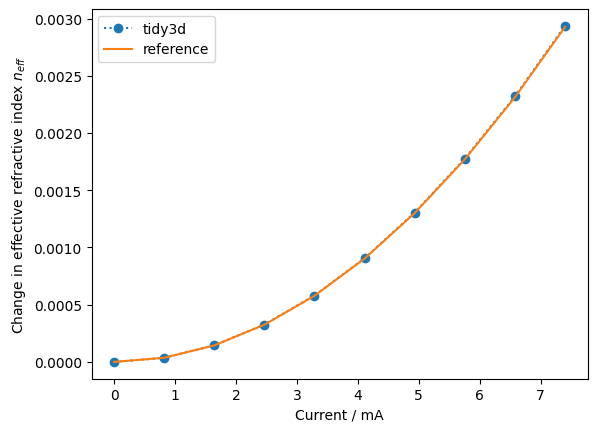

In [30]:
print(f"Phase shift over 320um: {2 * np.pi / 1.55 * (n_eff[-1] - n_eff[0]) * 320}")
print(
    f"Phase shift over 320um (ref): {2 * np.pi / 1.55 * (neff_ref[-1] - neff_ref[0]) * 320}"
)
plt.plot(currents * 1e3, n_eff[:] - n_eff[0], "o:")
plt.plot(currents_ref * 1e3, np.array(neff_ref) - neff_ref[0])
plt.xlabel("Current / mA")
plt.ylabel("Change in effective refractive index $n_{eff}$")
plt.legend(["tidy3d", "reference"])
plt.show()
